# Лабораторная работа №2

# Часть 1. Классификация изображений CIFAR100

## Импортирование необходимых библиотек

In [19]:
#!pip install torchsummary
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

## Определяем видеокарту GPU, чтобы на ней учить нейронную сеть

In [20]:
!nvidia-smi

Thu Dec 25 18:15:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             30W /   70W |     252MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Загрузка и распаковка набора данных CIFAR100

In [22]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

--2025-12-25 18:15:04--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz.1’

cifar-100-python.ta 100%[===================>] 161.17M  9.05MB/s    in 19s     

2025-12-25 18:15:25 (8.34 MB/s) - ‘cifar-100-python.tar.gz.1’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


## Чтение тренировочной и тестовой выборки

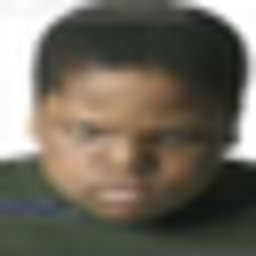

In [23]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [22, 11]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCWC -> NWHC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

## Создание Pytorch DataLoader'a

In [24]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7a1c25ebb380>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7a1c2629fcb0>}

## Создание Pytorch модели сверточной нейронной сети

In [41]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        # Предполагаем, что вход имеет формат [batch, height, width, channels]
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2)  # nhwc -> nchw

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=32, classes=100, pooling_type='avg'):
        super(Cifar100_CNN, self).__init__()

        # Добавьте это в __init__ класса Cifar100_CNN
        self.hidden_size = hidden_size

        self.pooling_type = pooling_type  # Тип пуллинга: 'avg', 'max' или 'stride'

        self.conv1 = nn.Conv2d(3, hidden_size, 5, stride=4, padding=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(hidden_size, hidden_size * 2, 3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pooling_layer = self.get_pooling_layer()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self._get_conv_output_size(), classes)

    def get_pooling_layer(self):
        if self.pooling_type == 'max':
            return nn.MaxPool2d(4)  # max pooling
        elif self.pooling_type == 'avg':
            return nn.AvgPool2d(4)  # average pooling
        elif self.pooling_type == 'stride':
            # Используем stride свертку с правильным количеством входных каналов
            return nn.Conv2d(self.hidden_size * 2, self.hidden_size * 2, 3, stride=2, padding=1)

    def _get_conv_output_size(self):
        with torch.no_grad():
            # Создаем тензор в формате NHWC
            x = torch.rand(1, 32, 32, 3)
            # Преобразуем в NCHW
            x = x.permute(0, 3, 1, 2)

            x = self.conv1(x)
            x = self.relu1(x)
            x = self.conv2(x)
            x = self.relu2(x)

            if self.pooling_type == 'stride':
                # Создаем временный слой для stride
                temp_pool = nn.Conv2d(self.hidden_size * 2, self.hidden_size * 2, 3, stride=2, padding=1)
                x = temp_pool(x)
            else:
                x = self.pooling_layer(x)

            x = self.flatten(x)
            return x.numel()

    def forward(self, input):
        # Если вход в формате NHWC, преобразуем в NCHW
        if input.dim() == 4 and input.shape[1] != 3 and input.shape[-1] == 3:
            input = input.permute(0, 3, 1, 2)

        x = self.conv1(input)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pooling_layer(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x



# Пример создания модели с Normalize
HIDDEN_SIZE = 32
normalize_layer = Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES), pooling_type='max')
model.to(device)

# Создайте последовательную модель
full_model = nn.Sequential(normalize_layer, model).to(device)

## Сравнение пулингов

In [42]:
def save_model(model, path, model_params):
    """Сохраняет модель с её параметрами."""
    torch.save({
        'model_state_dict': model.state_dict(),  # Сохраняем состояние модели (веса)
        'model_params': model_params,            # Сохраняем параметры модели
        'model_class': model.__class__.__name__  # Сохраняем имя класса модели
    }, path)
    print(f"Модель сохранена в {path}")

Training model: avg_pool
Training model: max_pool
Training model: stride_pool
Модель сохранена в best_model_avg_pool.pth
Лучшая модель сохранена: avg_pool с точностью 63.80%


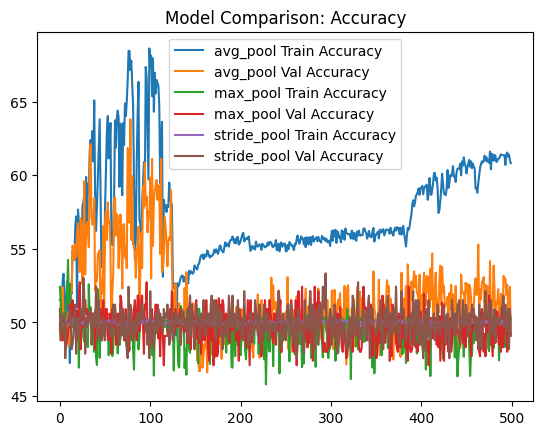

In [43]:
EPOCHS = 500

# Инициализация переменной для хранения лучшей модели
best_accuracy = 0.0
best_model_state = None
best_model_key = ""  # Изменим название переменной для ясности

# Функция для обучения и оценки модели
def train_and_evaluate(model, dataloader, criterion, optimizer, best_accuracy, best_model_state, best_model_key, model_key):
    losses = []
    losses_val = []

    for epoch in range(EPOCHS):
        tmp = []
        model.train()

        # Обучение модели
        for i, batch in enumerate(dataloader['train'], 0):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Прямой проход, вычисление ошибки и оптимизация
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            accuracy = (labels.detach().argmax(dim=-1) == outputs.detach().argmax(dim=-1)).to(torch.float32).mean().cpu() * 100
            tmp.append((loss.item(), accuracy.item()))

        losses.append(np.mean(tmp, axis=0))

        model.eval()
        tmp_val = []
        with torch.no_grad():
            # Валидация модели
            for i, data in enumerate(dataloader['test'], 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                accuracy = (labels.argmax(dim=-1) == outputs.argmax(dim=-1)).to(torch.float32).mean().cpu() * 100
                tmp_val.append((loss.item(), accuracy.item()))

        losses_val.append(np.mean(tmp_val, axis=0))

        # Отслеживание лучшей модели
        current_accuracy = np.mean([x[1] for x in tmp_val])  # Средняя точность на тестовой выборке
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_model_state = model.state_dict()  # Сохраняем модель с лучшей точностью
            best_model_key = model_key  # Сохраняем ключ модели (например 'avg_pool')

    return losses, losses_val, best_accuracy, best_model_state, best_model_key


# Модели с разными типами пуллинга
models_params = [
    ('avg_pool', 'avg'),
    ('max_pool', 'max'),
    ('stride_pool', 'stride')
]

models = {}
for model_key, pooling_type in models_params:
    model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES), pooling_type=pooling_type)
    model.to(device)
    models[model_key] = model

# Функция для тренировки и оценки всех моделей
results = {}
for model_key, model in models.items():
    print(f"Training model: {model_key}")

    # Определяем критерий потерь и оптимизатор для каждой модели
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)

    # Обучаем модель и оцениваем её
    losses, losses_val, best_accuracy, best_model_state, best_model_key = train_and_evaluate(
        model, dataloader, criterion, optimizer, best_accuracy, best_model_state, best_model_key, model_key)

    # Сохраняем результаты
    results[model_key] = (losses, losses_val)

# Сохраняем лучшую модель
if best_model_state is not None:
    # Загружаем лучшие веса в соответствующую модель
    models[best_model_key].load_state_dict(best_model_state)

    # Сохраняем модель с лучшим пуллингом
    save_model(models[best_model_key], f'best_model_{best_model_key}.pth', {
        'hidden_size': HIDDEN_SIZE,
        'classes': len(CLASSES),
        'pooling_type': models[best_model_key].pooling_type
    })

    print(f"Лучшая модель сохранена: {best_model_key} с точностью {best_accuracy:.2f}%")

# Сравнение графиков для каждой модели
for model_name, (losses, losses_val) in results.items():
    plt.plot([x[1] for x in losses], label=f'{model_name} Train Accuracy')
    plt.plot([x[1] for x in losses_val], label=f'{model_name} Val Accuracy')

plt.legend()
plt.title('Model Comparison: Accuracy')
plt.show()

## Выбор функции потерь и оптимизатора градиентного спуска

In [ ]:
criterion = nn.CrossEntropyLoss()
# используется SGD c momentum
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)

## Обучение модели по эпохам

  0%|          | 0/4000 [00:00<?, ?it/s]

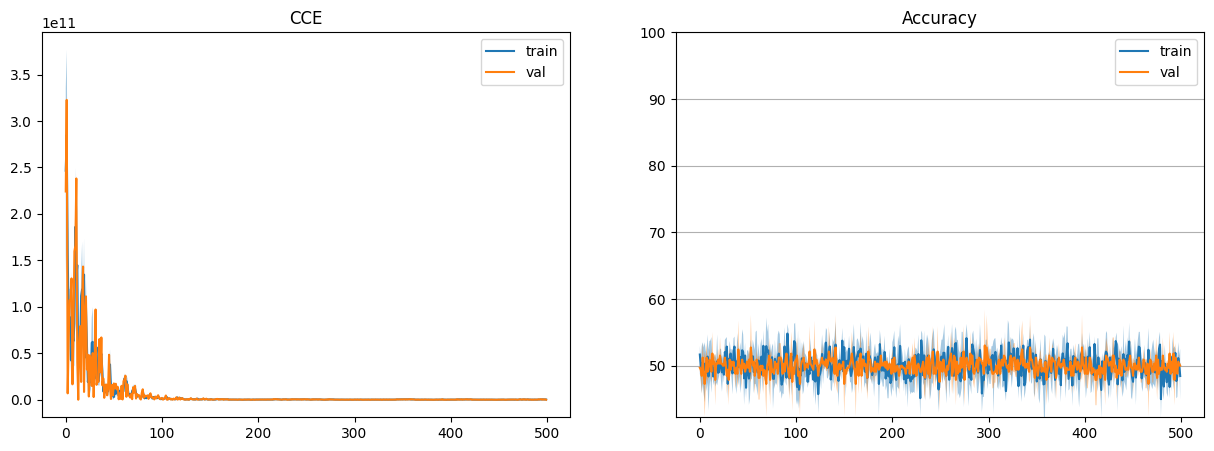

Обучение закончено за 27.532105922698975 секунд


In [ ]:
EPOCHS = 500
REDRAW_EVERY = 20
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])


# Создание прогресс-бара
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0

for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1) == outputs.detach().argmax(dim=-1)).to(torch.float32).mean().cpu() * 100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)

    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    tmp = []

    model.eval()
    with torch.no_grad():  # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            accuracy = (labels.argmax(dim=-1) == outputs.argmax(dim=-1)).to(torch.float32).mean().cpu() * 100
            tmp.append((loss.item(), accuracy.item()))

    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))

    if (epoch + 1) % REDRAW_EVERY != 0:
        continue

    clear_output(wait=False)
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS * steps_per_epoch, miniters=5)
    pbar.update((epoch + 1) * steps_per_epoch)

    x_vals = np.arange(epoch + 1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)

    ax[1].set_ylim(stats_val[:, 0, 1].min() - 5, 100)
    ax[1].grid(axis='y')

    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i], stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals, stats_val[:, 1, i], stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)

    plt.show()

print('Обучение закончено за %s секунд' % passed)


## Проверка качества модели по классам на обучающей и тестовой выборках

In [ ]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

# Часть 2. Сохранение модели в ONNX

In [44]:
def load_model(path, device='cpu'):
    """Загружает модель с проверкой совместимости"""
    checkpoint = torch.load(path, map_location=device)

    # Проверяем, что класс модели совпадает
    if checkpoint.get('model_class') != 'Cifar100_CNN':
        print("Внимание: Загружаемая модель другого класса!")

    # Создаем модель с сохраненными параметрами
    model_params = checkpoint['model_params']

    # Здесь нужно импортировать или определить класс Cifar100_CNN
    # Предполагаем, что класс Cifar100_CNN доступен в текущей области видимости
    model = Cifar100_CNN(**model_params)

    # Загружаем параметры
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    print(f"Модель загружена с параметрами: {model_params}")
    return model

In [45]:
# Загружаем сохраненную модель
model_path = './best_model_avg_pool.pth'  # Путь к сохраненной модели
loaded_model = load_model(model_path, device=device)

# Проверяем, что модель корректно загрузилась
loaded_model.eval()
print(f"Модель загружена на устройство: {device}")
print(f"Параметры модели: {loaded_model.hidden_size}, {loaded_model.classes}, {loaded_model.pooling_type}")

# Создаем фиктивный входной тензор для экспорта в ONNX
# Размер батча, каналы, высота, ширина
# CIFAR-100 изображения имеют размер 3x32x32
batch_size = 1
dummy_input = torch.randn(batch_size, 3, 32, 32, device=device)

# Экспорт в ONNX
onnx_path = 'cifar_cnn.onnx'

# Динамические оси для поддержки разных размеров батча
dynamic_axes = {
    'input': {0: 'batch_size'},   # динамическая размерность батча
    'output': {0: 'batch_size'}   # динамическая размерность батча
}

# Экспортируем модель в формат ONNX
torch.onnx.export(
    loaded_model,                  # модель
    dummy_input,                   # фиктивный вход
    onnx_path,                     # путь для сохранения ONNX файла
    export_params=True,            # сохранять веса модели
    opset_version=11,              # версия ONNX операторов
    do_constant_folding=True,      # оптимизация констант
    input_names=['input'],         # имя входного тензора
    output_names=['output'],       # имя выходного тензора
    dynamic_axes=dynamic_axes,     # динамические оси
    verbose=True                   # подробный вывод
)

print(f"Модель успешно экспортирована в ONNX: {onnx_path}")

Модель загружена с параметрами: {'hidden_size': 32, 'classes': 2, 'pooling_type': 'avg'}
Модель загружена на устройство: cuda


AttributeError: 'Cifar100_CNN' object has no attribute 'classes'

In [ ]:

!pip install onnx onnxscript onnxruntime

In [ ]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})

/tmp/ipython-input-4097618590.py:6: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(model,               # модель
W1219 22:06:58.738000 353 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 9 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `Cifar100_CNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Cifar100_CNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:68: adapter_lookup: Assertion `false`

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[s31,32,32,3]>
            ),
            outputs=(
                %"output"<FLOAT,[s31,2]>
            ),
            initializers=(
                %"conv1.bias"<FLOAT,[32]>{TorchTensor(...)},
                %"conv2.bias"<FLOAT,[64]>{TorchTensor(...)},
                %"pooling_layer.bias"<FLOAT,[64]>{TorchTensor(...)},
                %"fc.bias"<FLOAT,[2]>{TorchTensor<FLOAT,[2]>(Parameter containing: tensor([0.0040, 0.0371], device='cuda:0', requires_grad=True), name='fc.bias')},
                %"conv1.weight"<FLOAT,[32,3,5,5]>{TorchTensor(...)},
                %"conv2.weight"<FLOAT,[64,32,3,3]>{TorchTensor(...)},
                %"pooling_laye

# Loss landscape

In [ ]:
from copy import deepcopy
state_dict_backup = deepcopy(model.state_dict())

In [ ]:
def generate_theta(seed=None):
    model.eval()
    model.load_state_dict(state_dict_backup)
    if seed is not None:
        np.random.seed(seed)
    params = []
    with torch.no_grad():
        for w in model.parameters():
            params.append(w.detach().cpu().numpy())
    params_n = np.concatenate([p.flatten() for p in params]).size
    random_theta_flat = np.random.normal(size=params_n)
    random_theta = []
    offset = 0
    for p in params:
        p_weights = p.flatten().size
        random_theta.append(random_theta_flat[offset:offset+p_weights].\
                            reshape(*p.shape))
        # normalization
        rank = random_theta[-1].shape.__len__()
        if rank == 4: # convolution
            #print('Conv')
            # Frobenius norm
            norm_r = np.sqrt((random_theta[-1]**2).sum(axis=-1).sum(axis=-1))
            norm_p = np.sqrt((p**2).sum(axis=-1).sum(axis=-1))
            norm = (norm_p / norm_r).reshape(*norm_p.shape, 1, 1)
        elif rank == 2: # fully connected
            #print('FC')
            norm_r = np.sqrt((random_theta[-1]**2).sum(axis=-1))
            norm_p = np.sqrt((p**2).sum(axis=-1))
            norm = (norm_p / norm_r).reshape(-1, 1)
        elif rank == 1: # bias
            #print('bias')
            norm_r = np.sqrt((random_theta[-1]**2).sum())
            norm_p = np.sqrt((p**2).sum())
            norm = norm_p / norm_r
        random_theta[-1] = random_theta[-1]*norm
        offset += p_weights
    assert offset==params_n, \
            "Not all params are utilized. Expected %d, found %d"%(params_n, offset)
    return random_theta

theta1 = generate_theta(seed=0)
theta2 = generate_theta(seed=1011)

In [ ]:
criterion2 = nn.CrossEntropyLoss(reduction='none')
loss_curve = []
alphas = np.arange(-1500, 1500, step=5)/1000
for alpha in tqdm(alphas):
    state_dict = model.state_dict()
    for (k, v), v_new in zip(state_dict_backup.items(), theta1):
        tensor = v.clone().detach() + \
              alpha*(torch.tensor(v_new, device=device) - v.clone().detach())
        state_dict[k] = tensor
    model.load_state_dict(state_dict)
    loss = []

    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).detach()
            loss.append(criterion2(outputs, labels).detach().cpu().numpy())
    loss_curve.append(np.concatenate(loss).mean())

  0%|          | 0/600 [00:00<?, ?it/s]

Text(0, 0.5, 'CCE, log10')

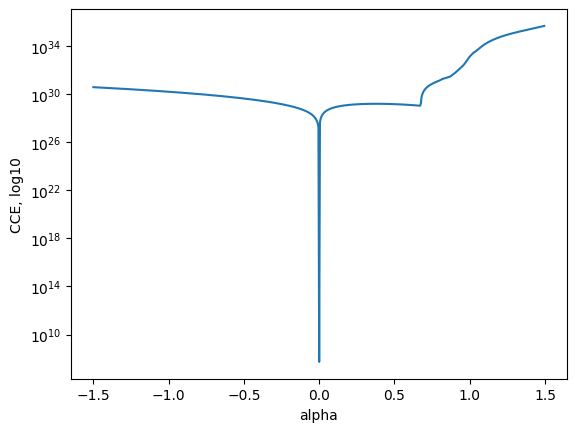

In [ ]:
plt.plot(alphas, loss_curve)
plt.yscale('log')
plt.xlabel('alpha')
plt.ylabel('CCE, log10')

## 2D

In [ ]:
# увеличив step, можно значительно ускорить вычисления
# однако вместе с этим теряется разрешение
alphas = []
vals = np.arange(-150, 151, step=5)/100
size = vals.size

# создаём заданный растр
for a1 in vals:
    for a2 in vals:
        alphas.append((a1, a2))

alphas = np.array(alphas)

In [ ]:
Z = []
for a1, a2 in tqdm(alphas):
    state_dict = model.state_dict()
    for (k, v), v_new, v_new2 in zip(state_dict_backup.items(), theta1, theta2):
        # линейная интерполяция
        tensor = v.clone().detach() + \
                 a1*(torch.tensor(v_new, device=device) - \
                     v.clone().detach())
        # ещё раз со вторым вектором
        tensor = tensor + a2*(torch.tensor(v_new2, device=device) - tensor)
        state_dict[k] = tensor
        #print(k, tensor, v_new)
    model.load_state_dict(state_dict)
    loss = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).detach()#.cpu().numpy()
            loss.append(criterion2(outputs, labels).detach().cpu().numpy())
    Z.append(np.concatenate(loss).mean())
ZZ = np.array(Z)

  0%|          | 0/3721 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [ ]:
# настройка размера графика
plt.figure(figsize=(8, 8))
# отрисовка закрашенных контуров, аналогично 2 части 1 ЛР
cs = plt.contourf(alphas[:,0].reshape(size, size),
             alphas[:,1].reshape(size, size),
             np.log10(ZZ.reshape(size, size)),
             levels=255,
             cmap=plt.cm.jet,
             )
# установка цветовой шкалы и её названия
plt.colorbar(cs).ax.set_ylabel('CCE, log10', rotation=270, fontsize=15)
# установка названий осям X, Y
plt.xlabel('α', fontsize=20)
plt.ylabel('β', fontsize=20)
plt.show()

## 3D

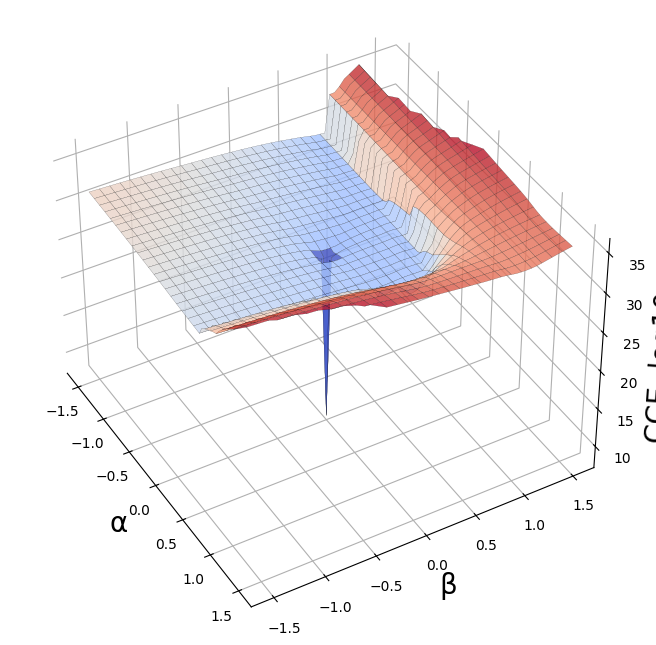

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
# установка названий осям X, Y и Z
ax.set_xlabel('α', fontsize=20)
ax.set_ylabel('β', fontsize=20)
ax.set_zlabel('CCE, log10', fontsize=20)
# выставление прозрачности сетки, для красоты
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# отрисовка 3D поверхности, данные для отрисовки аналогичны contourf
surf = ax.plot_surface(alphas[:,0].reshape(size, size),
                       alphas[:,1].reshape(size, size),
                       np.log10(ZZ.reshape(size, size)),
                       cmap=plt.cm.coolwarm,
                       linewidth=0.1,
                       edgecolors='k',
                       alpha=0.8,
                       antialiased=True)
# первый агрумент - вращение вокруг XY, второрй аргумент - вокруг YZ
ax.view_init(40, -30)